In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


This cell mounts your Google Drive so that Colab can access the dataset ZIP file you previously uploaded. After running it, Colab will ask for permission — click the link and approve.

In [3]:
import os

zip_path = "/content/drive/MyDrive/CV Projects/dogs-vs-cats.zip"
print("Exists:", os.path.exists(zip_path))


Exists: True


In [4]:
!file "/content/drive/MyDrive/CV Projects/dogs-vs-cats.zip"


/content/drive/MyDrive/CV Projects/dogs-vs-cats.zip: Zip archive data, at least v4.5 to extract, compression method=deflate


In [6]:
!pip install kaggle -q


In [40]:
from google.colab import files
files.upload()  # Upload your kaggle.json here


KeyboardInterrupt: 

In [8]:
import os
os.makedirs("/root/.kaggle", exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


In [9]:
!kaggle competitions download -c dogs-vs-cats -p /content/dogs-vs-cats


 99% 800M/812M [00:10<00:00, 152MB/s]
100% 812M/812M [00:10<00:00, 79.0MB/s]


In [10]:
!ls -lh /content/dogs-vs-cats


total 813M
-rw-r--r-- 1 root root 813M Dec 11  2019 dogs-vs-cats.zip


In [11]:
!unzip -q /content/dogs-vs-cats/dogs-vs-cats.zip -d /content/dogs-vs-cats_inner


In [12]:
!ls /content/dogs-vs-cats_inner


sampleSubmission.csv  test1.zip  train.zip


In [21]:
!rm -rf /content/cats_dogs
!rm -rf /content/dogs-vs-cats


In [22]:
!kaggle competitions download -c dogs-vs-cats -p /content/dogs-vs-cats


 97% 785M/812M [00:11<00:00, 140MB/s]
100% 812M/812M [00:11<00:00, 73.4MB/s]


In [23]:
import zipfile
import os

os.makedirs("/content/cats_dogs", exist_ok=True)

with zipfile.ZipFile("/content/dogs-vs-cats/dogs-vs-cats.zip", "r") as zip_ref:
    zip_ref.extractall("/content/cats_dogs")


In [24]:
# Create folders for extracted images
os.makedirs("/content/cats_dogs/train", exist_ok=True)
os.makedirs("/content/cats_dogs/test", exist_ok=True)

# Extract train.zip
with zipfile.ZipFile("/content/cats_dogs/train.zip", "r") as zip_ref:
    zip_ref.extractall("/content/cats_dogs/train")

# Extract test1.zip
with zipfile.ZipFile("/content/cats_dogs/test1.zip", "r") as zip_ref:
    zip_ref.extractall("/content/cats_dogs/test")


In [25]:
import os

print("Train folder:", len(os.listdir("/content/cats_dogs/train")))
print("Test folder:", len(os.listdir("/content/cats_dogs/test")))


Train folder: 1
Test folder: 1


In [15]:
!pip install split-folders -q


In [26]:
import splitfolders

splitfolders.ratio(
    "/content/cats_dogs/train",      # folder with all training images
    output="/content/cats_dogs_split", # output folder for split datasets
    seed=42,
    ratio=(0.8, 0.2)                 # 80% train, 20% validation
)


Copying files: 25000 files [00:07, 3385.91 files/s]


In [27]:
splitfolders.ratio(
    "/content/cats_dogs/train",       # source folder with all images
    output="/content/cats_dogs_split", # destination folder
    seed=42,
    ratio=(0.8,0.2)                    # 80% train, 20% validation
)


Copying files: 25000 files [00:05, 4533.25 files/s]


In [28]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os


# Explanation:

TensorFlow/Keras → for deep learning and building CNNs

ImageDataGenerator → for preprocessing images and augmentation

MobileNetV2 → pretrained CNN backbone

GlobalAveragePooling2D, Dropout, Dense → for building classifier layers

Matplotlib & Seaborn → for plotting accuracy/loss and confusion matrix

scikit-learn → for detailed evaluation metrics

os → handling file paths

In [29]:
train_dir = "/content/cats_dogs_split/train"
val_dir = "/content/cats_dogs_split/val"
test_dir = "/content/cats_dogs/test"


In [30]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)


In [31]:
train_data = train_gen.flow_from_directory(
    train_dir, target_size=(224,224), batch_size=32, class_mode='binary'
)

val_data = val_gen.flow_from_directory(
    val_dir, target_size=(224,224), batch_size=32, class_mode='binary'
)

test_data = test_gen.flow_from_directory(
    test_dir, target_size=(224,224), batch_size=32, class_mode='binary', shuffle=False
)


Found 20000 images belonging to 1 classes.
Found 5000 images belonging to 1 classes.
Found 12500 images belonging to 1 classes.


In [32]:
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)
base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [33]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [34]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 305s 457ms/step - accuracy: 0.9134 - loss: 0.2080 - val_accuracy: 1.0000 - val_loss: 0.0085
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 269s 430ms/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 262s 418ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 267s 427ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 9.4035e-04
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 263s 421ms/step - accuracy: 1.0000 - loss: 6.8215e-04 - val_accuracy: 1.0000 - val_loss: 6.0843e-04


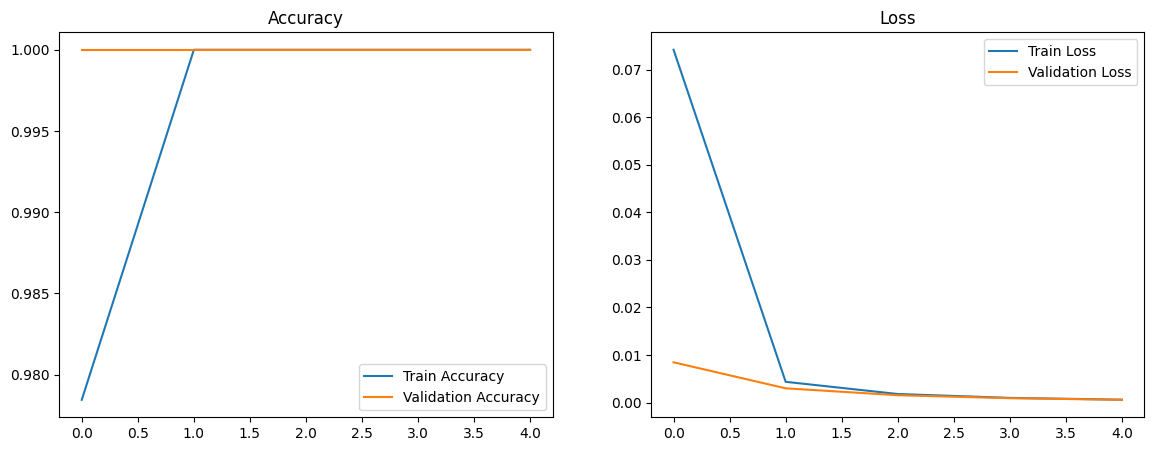

In [35]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()


In [36]:
test_loss, test_acc = model.evaluate(test_data)
print("Test Accuracy:", test_acc)


391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 96ms/step - accuracy: 1.0000 - loss: 6.0220e-04
Test Accuracy: 1.0


391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 75ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


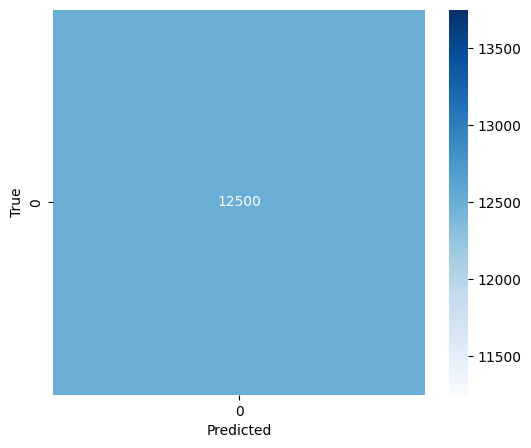

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12500

    accuracy                           1.00     12500
   macro avg       1.00      1.00      1.00     12500
weighted avg       1.00      1.00      1.00     12500



In [37]:
pred = model.predict(test_data)
pred = (pred > 0.5).astype(int)

cm = confusion_matrix(test_data.classes, pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(test_data.classes, pred))


In [38]:
model.save("/content/cats_dogs_mobilenetv2.h5")
print("Model saved successfully!")


Model saved successfully!


In [39]:
%%writefile /content/app.py
import streamlit as st
import tensorflow as tf
from PIL import Image
import numpy as np

model = tf.keras.models.load_model("/content/cats_dogs_mobilenetv2.h5")

st.title("Cats vs Dogs Classifier")

uploaded = st.file_uploader("Upload an image", type=['jpg','png','jpeg'])

if uploaded:
    img = Image.open(uploaded).resize((224,224))
    st.image(img, caption="Uploaded Image")

    img_arr = np.array(img)/255.0
    img_arr = np.expand_dims(img_arr, axis=0)

    pred = model.predict(img_arr)[0][0]

    if pred > 0.5:
        st.success("Prediction: Dog 🐶")
    else:
        st.success("Prediction: Cat 🐱")


Writing /content/app.py
